In [1]:
import kagglehub
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from collections import Counter
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
!chcp 65001
path = %pwd

Active code page: 65001


In [4]:
api.dataset_download_files("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews", path=path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


In [5]:
os.listdir()

['.ipynb_checkpoints', 'IMDB Dataset.csv', 'Untitled.ipynb', 'Untitled1.ipynb']

In [6]:
df = pd.read_csv('IMDB Dataset.csv')
print(len(df))
df.head()

50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [8]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [9]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)   # удалить HTML тэги 
    text = re.sub(r'[^a-zA-Z]', ' ', text) # оставить только английские буквы
    text = text.lower().split()
    return text
df['review'] = df['review'].apply(clean_text)

In [10]:
all_text = df['review'].values
words_count = Counter([word for text in all_text for word in text]) #частотный словарь
vocab = {word: i+1 for i, (word, _) in enumerate(words_count.most_common(10000))} # список слов с их индексами, используемый для преобразования текста в числа.

In [11]:
def text_to_sequence(text):
    return [vocab.get(word, 0) for word in text]

In [12]:
def sequence_to_text(sequence, vocab):
    reverse_vocab = {v: k for k, v in vocab.items()}  
    return ' '.join(reverse_vocab.get(num, '<UNK>') for num in sequence) 

In [13]:
sequences = [text_to_sequence(text) for text in all_text] #текст в числовую последовательность

In [14]:
max_len = 300
X = np.zeros((len(sequences), max_len), dtype=int) 
for i, seq in enumerate(sequences):
    length = min(len(seq), max_len)
    X[i, :length] = seq[:length]

y = df['sentiment'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train

array([[  11,   12,   47, ..., 1645,    1,  872],
       [   9,  117,   23, ...,    0,    0,    0],
       [   3, 1348,  110, ...,    0,    0,    0],
       ...,
       [ 783,   10,   28, ...,    0,    0,    0],
       [  10,  350,   13, ...,    0,    0,    0],
       [  10,    6,    3, ...,    0,    0,    0]])

In [25]:
y_train

array([0, 0, 1, ..., 0, 1, 1])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [18]:
class FNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(FNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * max_len, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [19]:
model = FNN(len(vocab) + 1, 32, 64).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Обучение модели с сохранением потерь
start_time = time.time()
epochs = 50
loss_history = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(train_loader))
    print(f"Эпоха {epoch+1}, Потери: {loss_history[-1]:.4f}")

print(time.time() - start_time)

Эпоха 1, Потери: 0.6621
Эпоха 2, Потери: 0.4000
Эпоха 3, Потери: 0.2352
Эпоха 4, Потери: 0.1642
Эпоха 5, Потери: 0.1172
Эпоха 6, Потери: 0.0817
Эпоха 7, Потери: 0.0562
Эпоха 8, Потери: 0.0399
Эпоха 9, Потери: 0.0268
Эпоха 10, Потери: 0.0167
Эпоха 11, Потери: 0.0557
Эпоха 12, Потери: 0.0134
Эпоха 13, Потери: 0.0044
Эпоха 14, Потери: 0.0036
Эпоха 15, Потери: 0.0050
Эпоха 16, Потери: 0.0116
Эпоха 17, Потери: 0.0081
Эпоха 18, Потери: 0.0063
Эпоха 19, Потери: 0.0106
Эпоха 20, Потери: 0.0100
Эпоха 21, Потери: 0.0038
Эпоха 22, Потери: 0.0010
Эпоха 23, Потери: 0.0006
Эпоха 24, Потери: 0.0006
Эпоха 25, Потери: 0.0005
Эпоха 26, Потери: 0.0005
Эпоха 27, Потери: 0.0237
Эпоха 28, Потери: 0.0078
Эпоха 29, Потери: 0.0023
Эпоха 30, Потери: 0.0007
Эпоха 31, Потери: 0.0005
Эпоха 32, Потери: 0.0005
Эпоха 33, Потери: 0.0005
Эпоха 34, Потери: 0.0004
Эпоха 35, Потери: 0.0038
Эпоха 36, Потери: 0.0217
Эпоха 37, Потери: 0.0073
Эпоха 38, Потери: 0.0013
Эпоха 39, Потери: 0.0005
Эпоха 40, Потери: 0.0005
Эпоха 41,

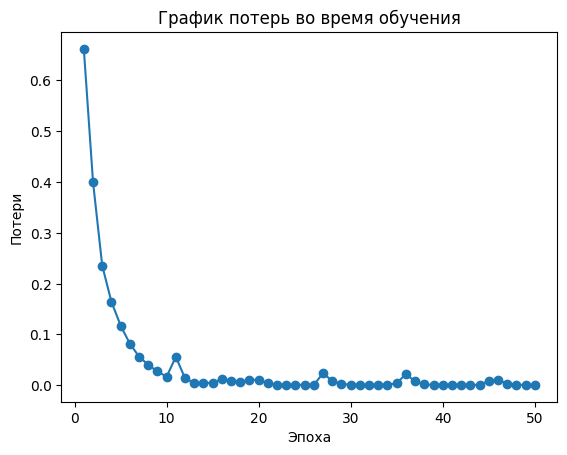

In [21]:
# Построение графика потерь
plt.plot(range(1, epochs+1), loss_history, marker='o', linestyle='-')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('График потерь во время обучения')
plt.show()

In [22]:
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

accuracy = np.mean((np.array(y_pred) > 0.5) == np.array(y_true))
print(f"Точность на тестовой выборке: {accuracy:.4f}")

Точность на тестовой выборке: 0.8232


In [23]:
torch.save(model, 'модель.pth')

In [ ]:
#model = torch.load('the_whole_shebang.pth')